# _Set Up_

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# fastai libraries
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import EarlyStoppingCallback

In [3]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os
from pathlib import Path

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# _Load in Data_

In [4]:
path = Config.data_path()
path

PosixPath('/home/jupyter/springboard-capstone-2/data')

In [5]:
# import data.py script to deal with data processing
from test_folder import data

# take 5% of data with seed of 8 and a single pathology, Cardiomegaly
train_df, valid_df = data.data_processing(path, 'Cardiomegaly', 8, 0.05);


(223414, 19)
(234, 19)
------------------------------
Extracted Patient ID from Path column and created new column named Patient_id
------------------------------
Created function named seed_data to set seed for sample data
------------------------------
Seeded data.
------------------------------
Created sample dataframe with input seed and 0.05% of original data
------------------------------
Created training and validation dataframe with expressed competition pathology, replacing NaN's with 0 and resetting the index
------------------------------

Cardiomegaly
------------------------------
Training shape
(11071, 2)

Validation shape
(234, 2)


In [13]:
train_df.head()

,Path,Cardiomegaly
0,CheXpert-v1.0-small/train/patient00006/study1/...,0.0
1,CheXpert-v1.0-small/train/patient00031/study1/...,0.0
2,CheXpert-v1.0-small/train/patient00031/study3/...,0.0
3,CheXpert-v1.0-small/train/patient00031/study2/...,0.0
4,CheXpert-v1.0-small/train/patient00044/study7/...,1.0


In [14]:
valid_df.head()

,Path,Cardiomegaly
0,CheXpert-v1.0-small/valid/patient64541/study1/...,1.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,0.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,0.0


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11071 entries, 0 to 11070
Data columns (total 2 columns):
Path            11071 non-null object
Cardiomegaly    11071 non-null float64
dtypes: float64(1), object(1)
memory usage: 173.1+ KB


In [16]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 2 columns):
Path            234 non-null object
Cardiomegaly    234 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.7+ KB


# _Checkout Values in Cardiomegaly Column_

In [17]:
train_df['Cardiomegaly'].value_counts()

 0.0    9320
 1.0    1344
-1.0     407
Name: Cardiomegaly, dtype: int64

In [18]:
valid_df['Cardiomegaly'].value_counts()

0.0    166
1.0     68
Name: Cardiomegaly, dtype: int64

Looks like we're good to go with the validation data set in that there are no uncertain (`-1`) values. But we'll have to do something about the training data set, which has 407 `-1.0` values. Additionally, we want to work with integers (model can run into complications when trying to classify the labels if we don't have them as integer types) so we'll convert the values in the `Cardiomegaly` column for both the training and validation set into integers. 

In [6]:
# can use data module from test_folder to utilize uzero function, which converts uncertain labels to negative labels and turns column
# integer type
train_df, valid_df = data.uzero(train_df, valid_df, 'Cardiomegaly');

In [7]:
train_df.head()

,Path,Cardiomegaly
0,CheXpert-v1.0-small/train/patient00006/study1/...,0
1,CheXpert-v1.0-small/train/patient00031/study1/...,0
2,CheXpert-v1.0-small/train/patient00031/study3/...,0
3,CheXpert-v1.0-small/train/patient00031/study2/...,0
4,CheXpert-v1.0-small/train/patient00044/study7/...,1


In [8]:
train_df['Cardiomegaly'].value_counts()

0    9727
1    1344
Name: Cardiomegaly, dtype: int64

In [9]:
9320 + 407

9727

In [10]:
valid_df['Cardiomegaly'].value_counts()

0    166
1     68
Name: Cardiomegaly, dtype: int64

As we can see `data.uzero` converted the uncertain (`-1`) labels in `train_df` to negative (`0`) labels, then converted them to integers. Also looks like it successfully converted the values to integer types in the same column for the validation set. With our data sets in hand, we're now able to move onto the deep learning phase!

# _DL Set Up_

In [11]:
from test_folder import deeplearning

data = deeplearning.baseline_setup(path, train_df, valid_df, 'Cardiomegaly')

Created ImageList from train_df and randomly split 20% of data for validation set.
------------------------------
using bs=16, have 7601MB of GPU RAM free.
------------------------------
Created ImageDataBunch.
------------------------------
Created test set
------------------------------
The following print out contains information regarding training, validation and test data sets for ImageDataBunch.
ImageDataBunch;

Train: LabelList (8857 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,0,1
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (2214 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
0,0,0,1,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: LabelList (234 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: EmptyLabelList
,,,,
Path: 

# _Set Up DL Model_

In [12]:
# create a pretrained densenet121 cnn_learner with error rate and AUROC as the metrics with a ps of 0.5 (i.e. 50% of randomly selected neurons will be ignored from the n-1 layer) and batch normalization
learn = cnn_learner(data=data, base_arch=models.densenet121, metrics=[error_rate, AUROC()], pretrained=True,
                     ps=0.5, bn_final=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.00E-01
Min loss divided by 10: 7.94E-02


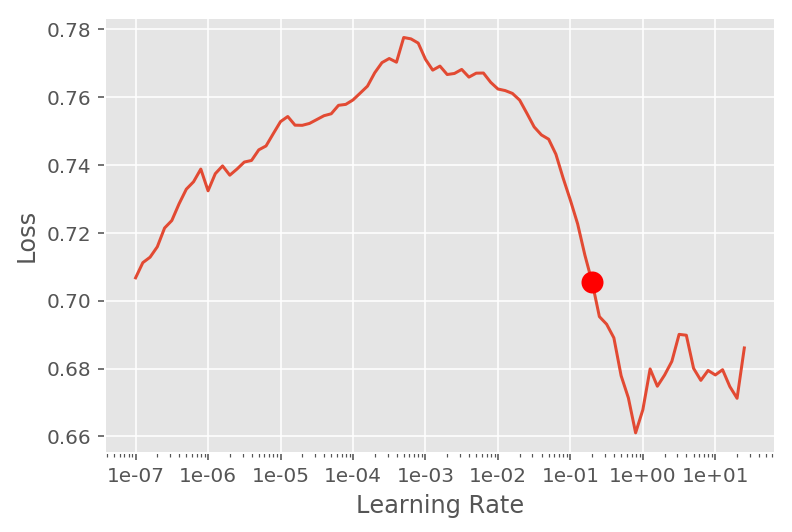

In [37]:
deeplearning.lr_finder_plot(learn)

In [40]:
# were going to set the learning rate to the min numerical gradient (i.e. the red dot)
lr = learn.recorder.min_grad_lr
lr

0.1995262314968879

In [41]:
# check the loss function
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

# _First Round of Training_

In [42]:
learn.fit_one_cycle(5, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.371723,0.383378,0.122855,0.540379,01:25
1,0.391976,1.677399,0.123306,0.405521,01:13
2,0.367634,0.405528,0.122855,0.445617,01:14
3,0.355306,0.363742,0.122855,0.651718,01:14
4,0.340870,0.808825,0.124661,0.708233,01:14


In [43]:
# save model weights so far
learn.save('trial17-rd1')

# _Second Round of Training_

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-07
Min loss divided by 10: 3.16E-05


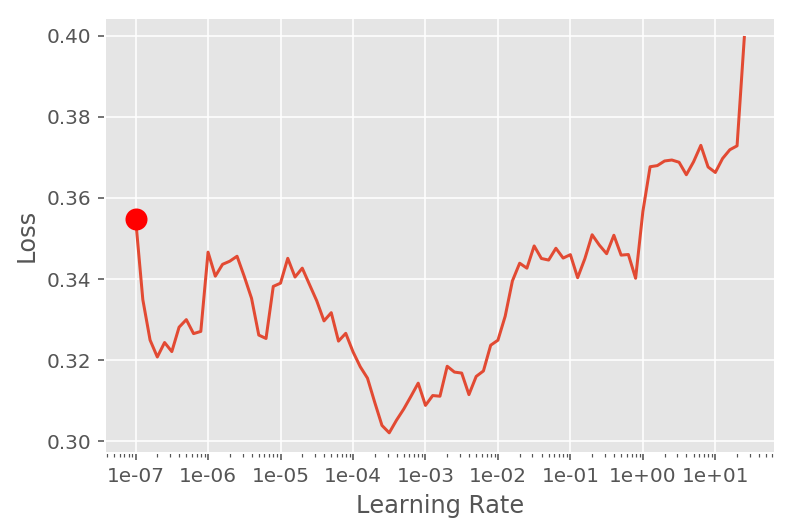

In [46]:
# unfreeze all layers then find appropriate learning rate
learn.unfreeze()

deeplearning.lr_finder_plot(learn)

In [47]:
lr = 1e-4
lr

0.0001

In [49]:
# load the previous weights
learn.load('trial17-rd1');

In [51]:
# train model
learn.fit_one_cycle(5, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.361547,0.348860,0.124210,0.714843,01:38
1,0.341186,0.348340,0.123758,0.703249,01:37
2,0.340362,1.328640,0.121951,0.722131,01:38
3,0.364975,0.335698,0.121951,0.735703,01:36
4,0.319833,0.375305,0.122403,0.741668,01:36


In [52]:
# save model weights for second round of training
learn.save('trial17-rd2')

# _Third Round of Training_

In [13]:
# load the previous weights
learn.load('trial17-rd2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-07
Min loss divided by 10: 3.98E-08


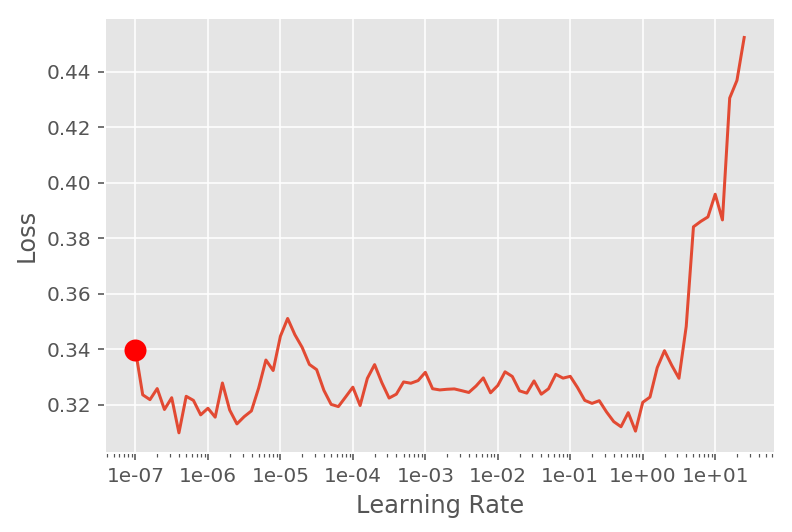

In [14]:
# find appropriate learning rate
deeplearning.lr_finder_plot(learn)

In [15]:
# train model using slice, training lower layers at smaller learning rate than higher levels
learn.fit_one_cycle(5, slice(1e-7, 0.9), callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.396032,0.356146,0.123306,0.756748,01:24
1,0.396183,0.336324,0.127371,0.776364,01:12
2,0.397115,0.474822,0.150858,0.756043,01:15
3,0.317115,0.337016,0.123306,0.779359,01:13


Epoch 4: early stopping


In [16]:
# save the weights so far
learn.save('trial17-rd3')

# _Gather New Sample and Alter Image Size to 128_

In [42]:
# import data.py script to deal with data processing
from test_folder import data

# take 5% of data with seed of 50 and a single pathology, Cardiomegaly
train_df, valid_df = data.data_processing(path, 'Cardiomegaly', 50, 0.05);


(223414, 19)
(234, 19)
------------------------------
Extracted Patient ID from Path column and created new column named Patient_id
------------------------------
Created function named seed_data to set seed for sample data
------------------------------
Seeded data.
------------------------------
Created sample dataframe with input seed and 0.05% of original data
------------------------------
Created training and validation dataframe with expressed competition pathology, replacing NaN's with 0 and resetting the index
------------------------------

Cardiomegaly
------------------------------
Training shape
(11194, 2)

Validation shape
(234, 2)


In [43]:
# can use data module from test_folder to utilize uzero function, which converts uncertain labels to negative labels and turns column
# integer type
train_df, valid_df = data.uzero(train_df, valid_df, 'Cardiomegaly');

In [44]:
from test_folder import deeplearning

data_128 = deeplearning.baseline_setup(path, train_df, valid_df, 'Cardiomegaly', image_size=128)

Created ImageList from train_df and randomly split 20% of data for validation set.
------------------------------
using bs=16, have 7016MB of GPU RAM free.
------------------------------
Created ImageDataBunch with size = 128
------------------------------
Created test set
------------------------------
The following print out contains information regarding training, validation and test data sets for ImageDataBunch.
ImageDataBunch;

Train: LabelList (8956 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (2238 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,0,1
Path: /home/jupyter/springboard-capstone-2/data;

Test: LabelList (234 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Imag

In [45]:
# switch data to data_128
learn.data = data_128

# _Fourth Round of Training (w/ new data whose image size is 128)_

In [46]:
# load the previous weights
learn.load('trial17-rd3');

In [47]:
# unfreeze all layers then find appropriate learning rate
#learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E-06
Min loss divided by 10: 1.00E-04


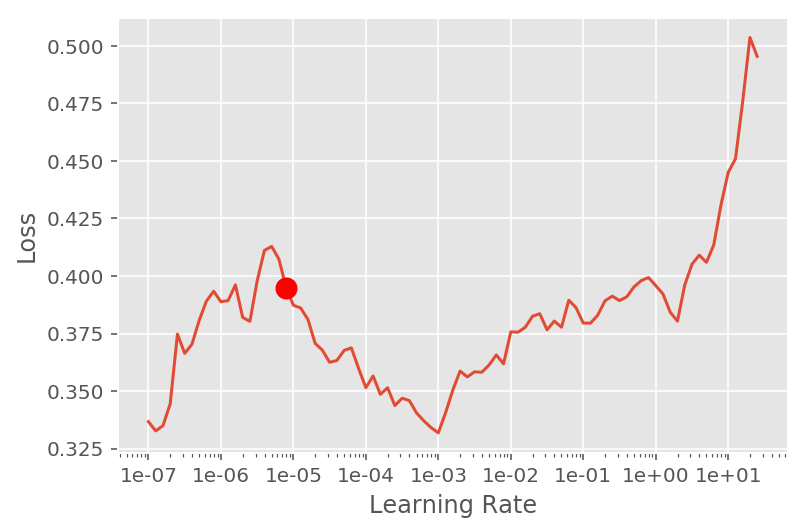

In [48]:
# find appropriate learning rate
deeplearning.lr_finder_plot(learn)

In [49]:
lr = 9e-5
lr

9e-05

In [50]:
learn.fit_one_cycle(5, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=3)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.354514,0.385339,0.137623,0.755842,02:03
1,0.345235,0.352954,0.134942,0.776921,01:56
2,0.322662,0.395015,0.136282,0.769393,01:55
3,0.308488,0.336148,0.134495,0.792013,01:55
4,0.337320,0.334731,0.133601,0.793740,01:56


In [51]:
learn.save('trial17-rd4')

# _Fifth Round of Training_

In [52]:
# load the previous weights
learn.load('trial17-rd4');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 3.16E-07


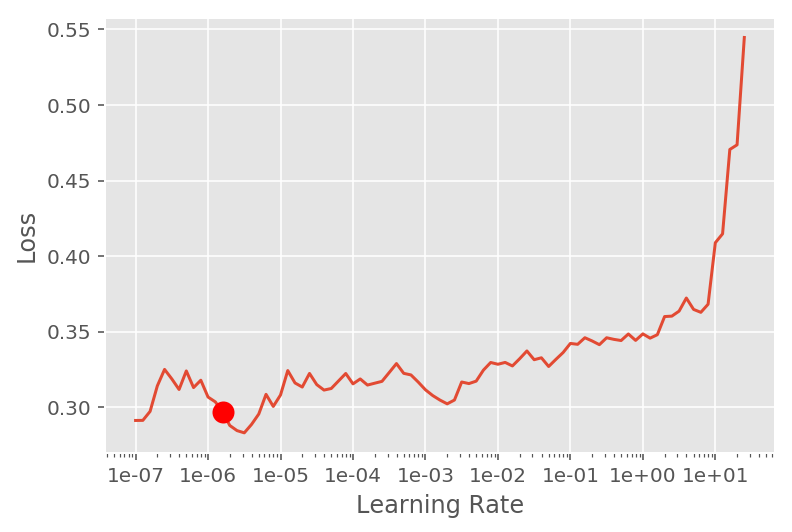

In [53]:
# unfreeze all layers then find appropriate learning rate
learn.unfreeze()

# find appropriate learning rate
deeplearning.lr_finder_plot(learn)

In [54]:
lr = 1e-06
lr

1e-06

In [55]:
learn.fit_one_cycle(5, lr, callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.291797,0.332712,0.133155,0.794290,01:55
1,0.321161,0.336508,0.134495,0.797271,01:55
2,0.344049,0.334075,0.132708,0.796706,01:56


Epoch 3: early stopping


In [57]:
# save weights so far
learn.save('trial17-rd5')

# _Gather New Sample and Alter Image Size to 256_

In [70]:
# import data.py script to deal with data processing
from test_folder import data

# take 5% of data with seed of 50 and a single pathology, Cardiomegaly
train_df, valid_df = data.data_processing(path, 'Cardiomegaly', 175, 0.05);


(223414, 19)
(234, 19)
------------------------------
Extracted Patient ID from Path column and created new column named Patient_id
------------------------------
Created function named seed_data to set seed for sample data
------------------------------
Seeded data.
------------------------------
Created sample dataframe with input seed and 0.05% of original data
------------------------------
Created training and validation dataframe with expressed competition pathology, replacing NaN's with 0 and resetting the index
------------------------------

Cardiomegaly
------------------------------
Training shape
(11389, 2)

Validation shape
(234, 2)


In [71]:
# can use data module from test_folder to utilize uzero function, which converts uncertain labels to negative labels and turns column
# integer type
train_df, valid_df = data.uzero(train_df, valid_df, 'Cardiomegaly');

In [72]:
from test_folder import deeplearning

data_256 = deeplearning.baseline_setup(path, train_df, valid_df, 'Cardiomegaly', image_size=256)

Created ImageList from train_df and randomly split 20% of data for validation set.
------------------------------
using bs=16, have 7018MB of GPU RAM free.
------------------------------
Created ImageDataBunch with size = 256
------------------------------
Created test set
------------------------------
The following print out contains information regarding training, validation and test data sets for ImageDataBunch.
ImageDataBunch;

Train: LabelList (9112 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Valid: LabelList (2277 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/springboard-capstone-2/data;

Test: LabelList (234 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Imag

In [73]:
# switch data to data_256
learn.data = data_256

# _Sixth Round of Training_

In [74]:
# load the previous weights
learn.load('trial17-rd5');

# freeze lower layers
#learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-07
Min loss divided by 10: 6.31E-03


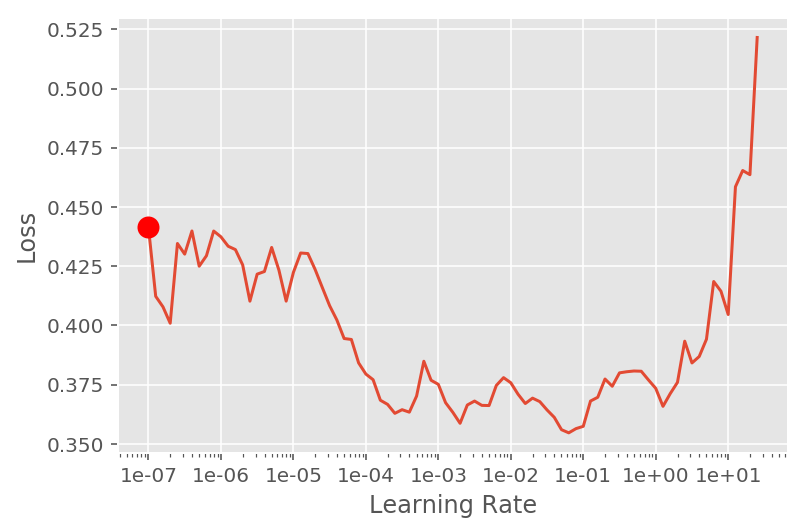

In [75]:
# find appropriate learning rate
deeplearning.lr_finder_plot(learn)

In [76]:
lr = 5e-5
lr

5e-05

In [78]:
learn.fit_one_cycle(5, slice(1e-4, 1e-2), callbacks=[EarlyStoppingCallback(learn, monitor='auroc', min_delta=0.01, patience=2)])

epoch,train_loss,valid_loss,error_rate,auroc,time
0,0.398669,0.367353,0.128678,0.680210,02:27
1,0.363418,0.371411,0.128239,0.708303,02:27
2,0.353196,0.347013,0.127800,0.724361,02:27
3,0.338649,0.346011,0.127361,0.726168,02:27
4,0.357701,0.345006,0.127361,0.730948,02:28


In [79]:
learn.save('trial17-rd6')